# MobileNet V2 SSD Tensorflow로 구현해보기 실습
지난 실습 때 MobileNet V2를 이용하여 이미지 분류를 하는 모델을 학습하였다. 이번 실습에서는 조금 더 나아가 이미지 안의 물체를 탐지하는 네트워크를 실습해 볼 것이다. 지난 시간에 다뤘던 MobileNet V2에 SSD(Single Shot Detection)를 추가해 물체 탐지를 해보자. <br>

In [2]:
import os
import socket
import pickle
import time
import math
import numpy as np
import cv2
import struct
from tqdm import tqdm
from sys import getsizeof
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import model_selection

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Add, ReLU, Input, Dense, Dropout, Activation, Flatten \
    , Conv2D, MaxPooling2D, InputLayer, Reshape, DepthwiseConv2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.python.keras import backend
# from tensorflow.python.keras.utils import layer_utils
from keras.applications import imagenet_utils


## Setting GPU
GPU가 없으면 아래 Step은 건너뛰어도 좋다.

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_visible_devices(gpu, 'GPU')
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

## Setting Hyperparameters
SSD의 주요 Parameter들을 아래와 같이 설정해 주자.

In [4]:
IMG_SIZE = 224
n_classes = 10
pos_iou_threshold = 0.3
neg_iou_threshold = 0.3
score_threshold = 0.01
layer_width=[14,7,4,2,1]
num_boxes = [3,3,3,3,3]
aspect_ratio = [1,2,1/2]
s_max = 0.9
s_min = 0.5
batch_size = 16
log_dir = './'
model_name = 'mobilenetSSD'
model_csv_path  = os.path.join(log_dir, (model_name + '.csv'))

## Dataset

데이터셋은 cifar 10을 이용할 것이다. 다만, cifar 10은 이미지분류를 위한 데이터셋으로 Object detection 모델을 훈련시키기에는 적합하지 않으므로, 이를 적절하게 변형해주는 작업을 추가로 수행할 것이다. 먼저 데이터셋을 로드한다.

In [5]:
#Load data
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

train_size = x_train.shape[0]
test_size = x_test.shape[0]

아래는 SSD 데이터 전처리를 위한 Utility function들이다. 
1. `def calc_iou(gt, anchor_boxes):` <br>두 Bounding box를 Input으로 받아 IoU(Intersection over Union)을 계산한다. 입력된 array의 마지막 dimension의 마지막 4자리를 Bounding box로 보고, 입력 포맷은 Corner 스타일(xmin, ymin, xmax, ymax) 이어야 한다.
2. `def match_bipartite_greedy(weight_matrix):`  <br>각 Ground Truth별로 가장 많이 겹치는 Anchor box를 찾기 위한 함수. (Ground Truth) x (Anchor boxes) 형태의 IoU Matrix를 입력으로 받아 각 Ground Truth마다 가장 IoU가 높은 Anchor box를 찾아준다.
3. `def match_multi(weight_matrix, threshold):`  <br>match_bipartite_greedy에서는 해당되지 않지만, IoU가 높은 Anchor box들에 대해서도 Ground Truth를 매칭시켜주기 위한 함수.  각 Anchor box별로 iou가 특정 임계값보다 높은 Ground Truth 중 IoU가 가장 높은 Ground Truth를 찾아준다.
4. `def convert_coord(boxes, type='centroid2corner'):` <br>좌표값 표현 포맷을 변환해주는 함수. Centroid(cx, cy, w, h)와 Corner(xmin, ymin, xmax, ymax) 스타일 간에 변환이 가능하다.

In [6]:
from utils import calc_iou, match_bipartite_greedy, match_multi, convert_coord

### SSDInputEncodingGenerator
cifar10 데이터를 batch 단위로 입력받아 아래의 작업을 통해 SSD를 위한 데이터를 생성한다.

1. 32x32 이미지 데이터를 입력받은 뒤, 64 x 64로 확대하고, 224x224 검은 이미지에 랜덤하게 배치하여 트레이닝용 이미지로 한다. 이때 배치한 좌표의 위치를 Ground Truth의 좌표로 정의하고 다음 단계에서 적절한 Label 포맷으로 변형한다.
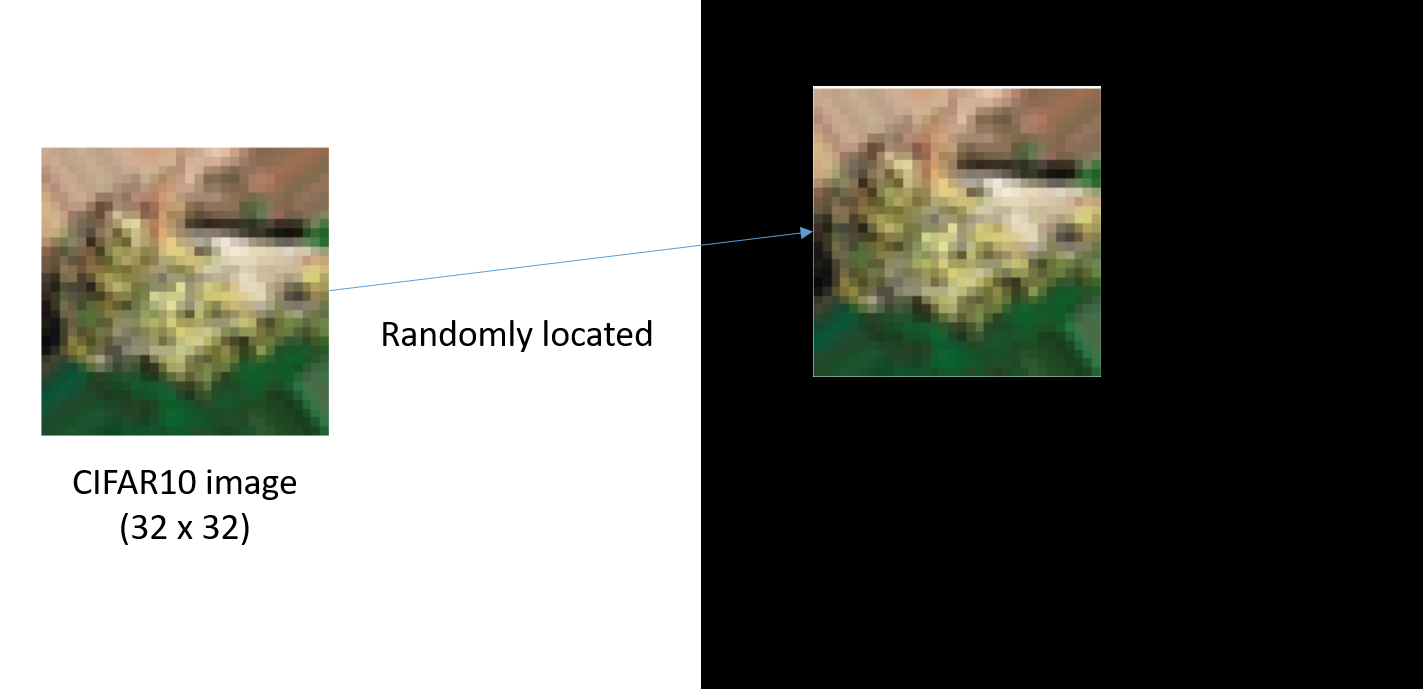
2. Detection용 Label을 생성한다. SSD에는 총 6개의 Detection 레이어가 있고, 각 레이어마다 격자를 나누고 4개/6개의 서로 다른 모양을 갖는 Anchor box를 배치한다. 각 Anchor box는 4개의 좌표값과(cx, cy, w, h), 10개의 클래스별 확률로 정의된다. Default class는 Background로 정의하고 다음 단계에서 매칭된 Box들만 Class를 부여해준다.
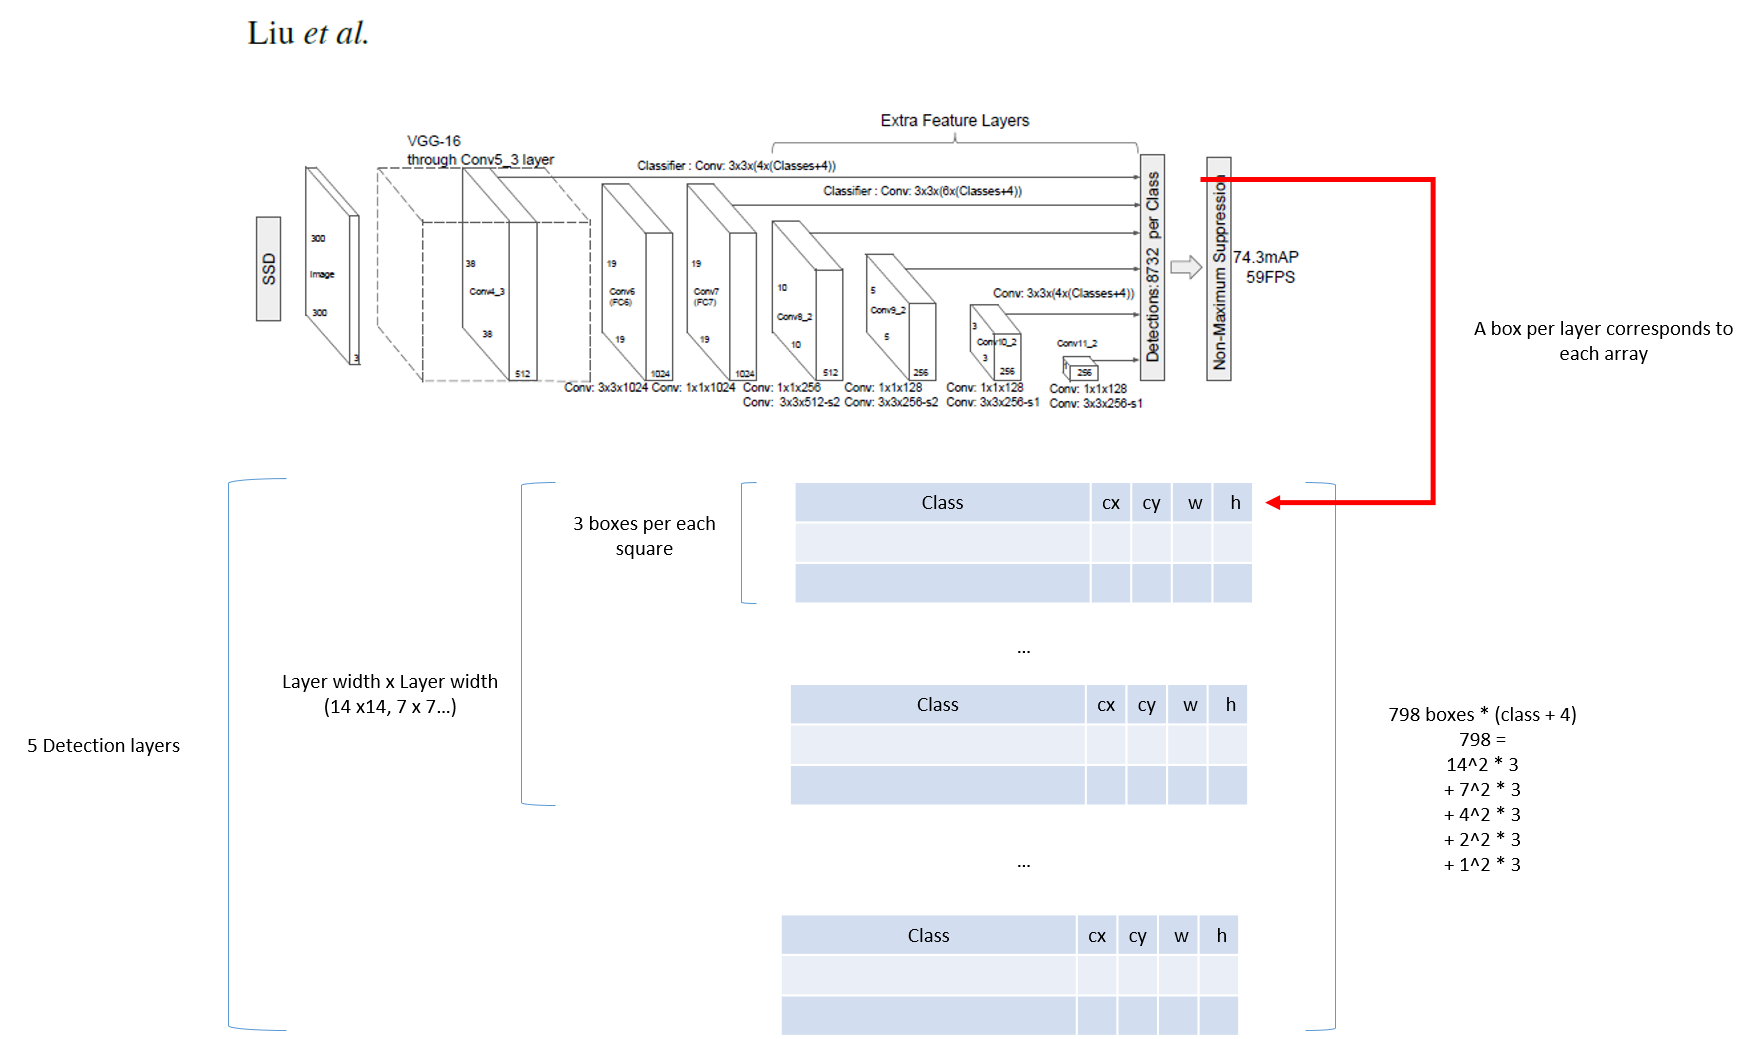
3. 위에서 설명한 calc_iou, match_bipartite_greedy, match_multi 등의 함수를 이용하여 Anchor box중 Ground truth와 많이 겹치는 Box들을 찾는다. 이렇게 찾은 Anchor Box에 class를 지정해주고, 아래의 수식에 따라 loss 계산에 필요한 값들을 정의한다.  d는 anchorbox, g는 ground truth를 의미하며 윗첨자들은 각 좌표값(cx, cy, w, h)에 해당된다.
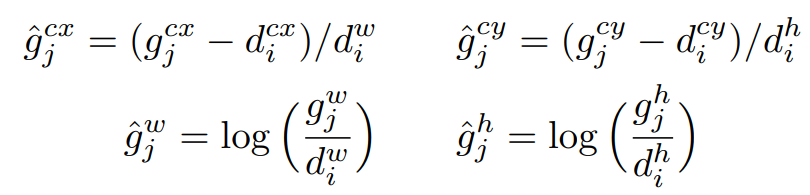

In [7]:
class SSDInputEncodingGenerator(keras.utils.Sequence):
    def __init__(self, 
                 img_height, 
                 img_width, 
                 layer_width, 
                 n_classes, 
                 num_boxes, 
                 s_max, 
                 s_min, 
                 aspect_ratio, 
                 pos_iou_threshold,
                 neg_iou_threshold,
                background_id,
                 images,
                 labels, 
                 data_size,
                batch_size=32):
        #Consider Background class
        self.img_height = img_height
        self.img_width = img_width
        self.n_class_withbg = n_classes + 1  #Add background class
        self.num_boxes = num_boxes  #List of number of boxes in each classifier layer
        self.s_max = s_max # Largest scale of default box
        self.s_min = s_min # Smallest scale of default box
        self.aspect_ratio = aspect_ratio # List of aspect ratios
        self.layer_width = layer_width
        self.pos_iou_threshold = pos_iou_threshold
        self.neg_iou_threshold = neg_iou_threshold
        self.background_id = background_id
        self.batch_size=batch_size
        self.images = images
        self.labels = labels
        self.shuffle = False
        self.data_size = data_size
        
        self.xmin_random = np.random.randint(self.img_height - 64, size=[self.data_size])
        self.ymin_random = np.random.randint(self.img_height - 64, size=[self.data_size])
        
        self.on_epoch_end()
        
    def convert_image(self, image, label, indexes):
        """
        Convert classification data to object detection data
        Randomly locate image in the middle of black canvas    
        Input
            x: Image, shape: (batch_size, image size, image size, #channels)
            y: label, shape: (batch_size, )
        output
            out_x: Image located in the random location of black canvas, shape: (batch_size, canvas size, canvas size, 3)
            out_y: label and location of corners(xmin,ymin,xmax,ymax), shape: (batch_size, #objects per image, 1+4) #Objects per image = 1

        """
        orig_image_size = 64
        channels = image.shape[-1]

        #prepare black canvas
        canvas = np.zeros((self.batch_size, self.img_height, self.img_width, channels), dtype=np.int)
        out_y = np.zeros((self.batch_size, 1, 5))

        xmin = self.xmin_random[indexes]
        ymin = self.ymin_random[indexes]
        xmax = xmin + orig_image_size
        ymax = ymin + orig_image_size

        
        resized = np.zeros((orig_image_size, orig_image_size, 3))
        for i in range(batch_size):
            resized = cv2.resize(image[i], dsize=(orig_image_size, orig_image_size))
            canvas[i, xmin[i]:xmax[i], ymin[i]:ymax[i], :] = resized

        out_y[:, 0,0] = label[:,0]
        out_y[:, 0, -4:] = np.column_stack([xmin, ymin, xmax, ymax])

        return canvas, out_y
        
    def __getitem__(self, index):
        '''
        Generate one batch of data
        '''
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y
    
    def on_epoch_end(self):
        '''
        Updates indexes after each epoch
        '''
        self.indexes = np.arange(self.data_size)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(self.images.shape[0] / self.batch_size))
        
    def __data_generation(self, indexes):
        """
        Input: ground truth label,shape: (batch_size, #object per image, 1 + 4)
        Output: y_encoded, shape: (batch_size, sum of grid size of all classifier * num_boxes, n_class_withbg + 4 + 4)
        1. Create y_encoded template: (B, num_boxes, class + 4 + 4) 4 for gt coordinates and 4 for anchor boxes
        2. For each ground truth, calculate iou of gt and anchor boxes
        3. Find the highest matching anchor box per each gt and fill in y_encoded template
        4. Multi object matching
        5. Apply negative iou threshold
        6. Transform into Delta format
        """
        
        images, gt_label = self.convert_image(self.images[indexes], self.labels[indexes], indexes)        
        
        # Make class vector to one hot format
        class_vector = np.eye(self.n_class_withbg)        
        
        #layer_width=[14,7,4,2,1]
        for iw in range(len(layer_width)):
            # s_max = 0.9  s_min = 0.5
            s = s_min + (s_max - s_min) / (len(layer_width) - 1) * (len(layer_width) - iw - 1)
            l = layer_width[iw]            
            num_box = self.num_boxes[iw]       # num_boxes = [3,3,3,3,3]  
            box_tensor = np.zeros((l * l * num_box, 4))
            ### 아래 실습하면서 완성
            for i in range(l):
                for j in range(l):
                    for box_idx in range(num_box):
                        box_tensor[(i * l + j) * num_box + box_idx, 0] = (0.5 + i) / l
                        box_tensor[(i * l + j) * num_box + box_idx, 1] = (0.5 + j) / l
                        # aspect_ratio = [1, 1/2, 2] 
                        box_tensor[(i * l + j) * num_box + box_idx, 2] = math.sqrt(aspect_ratio[box_idx]) / l * s
                        box_tensor[(i * l + j) * num_box + box_idx, 3] = 1 / math.sqrt(aspect_ratio[box_idx]) / l * s
            ### 실습 끝

            box_tensor = convert_coord(box_tensor, type='centroid2corner')
            
            if iw == 0:
                boxes_tensor = box_tensor                
            else:                    
                boxes_tensor = np.concatenate((boxes_tensor, box_tensor), axis = 0)
            
            class_tensor = np.zeros((l * l * num_box , self.n_class_withbg))
            
            if iw == 0:
                classes_tensor = class_tensor                
            else:                    
                classes_tensor = np.concatenate((classes_tensor, class_tensor), axis = 0)
                
        box_class_tensor= np.concatenate((classes_tensor, boxes_tensor, boxes_tensor), axis = 1)
        y_encoded = np.tile(box_class_tensor, (self.batch_size, 1, 1))
        
        y_encoded[:, :, self.background_id] = 1 # All boxes are background boxes by default.
        
    
        #Ground truth matching
        for i in range(self.batch_size):
            gt_one_label = gt_label[i]
            m = gt_one_label.shape[0]
            if gt_one_label.shape[0] == 0: continue # If there is no object, skip
            
            #Normalize ground truth
            gt_one_label[:,[-4,-2]] /= self.img_width
            gt_one_label[:,[-3,-1]] /= self.img_height
            
            #FInd the iou of ground truth and all anchor boxes
            similarities = calc_iou(gt_one_label[:,-4:], y_encoded[i, :, -4:])            
            
            #Find the highest matching anchor box per each ground truth boxes
            matches = match_bipartite_greedy(similarities)
            
            #Convert ground truth class label to one hot encoding            
            gt_class = np.array(gt_one_label[:,0] + 1, dtype=np.int)
                        
            #Fill in y_encoded
            y_encoded[i, matches, :self.n_class_withbg] = class_vector[gt_class]
            y_encoded[i, matches, -8:-4] = gt_one_label[:,1:]
            
            #Set the matched anchor boxes to 0 to indicate they are matched before multi object matching
            similarities[:,matches] = 0
            
            
            #Multi object matching
            #Similar process to bipartite matching
            matches_anchor, matches_gt = match_multi(similarities, threshold=self.pos_iou_threshold)            
            
            if len(matches_gt) > 0:            

                y_encoded[i, matches_anchor, :self.n_class_withbg] = class_vector[gt_class[matches_gt]]           
                y_encoded[i, matches_anchor, -8:-4] = gt_one_label[matches_gt,1:]

                #Set the matched anchor boxes to 0 to indicate they are matched before applying negative iou threshold
                similarities[:,matches_anchor] = 0
            
            #All background boxes whose iou are greater than neg_iou_threshold 
            # are set to neutral(neither background nor class)
            max_bg_similarities = np.amax(similarities, axis = 0)
            neutral_boxes = np.nonzero(max_bg_similarities >= self.neg_iou_threshold)[0]
            y_encoded[i, neutral_boxes, self.background_id] = 0
        
        #Convert coordinate from corner 2 centroid
        y_encoded[:,:,:-4] = convert_coord(y_encoded[:,:,:-4], type='corner2centroid')
        #print(y_encoded[0,0])
        y_encoded = convert_coord(y_encoded, type='corner2centroid')        
        #print(y_encoded[0,0])
        
        y_encoded[:,:,[-8, -7]] -= y_encoded[:,:,[-4, -3]] # (cx(gt) - cx(d_box)) # (cy(gt) - cy(d_box))
        y_encoded[:,:,[-8, -7]] /= y_encoded[:,:,[-2, -1]] # (cx(gt) - cx(d_box)) / w(d_box) # (cy(gt) - cy(d_box)) / h(d_box)
        y_encoded[:,:,[-6, -5]] = np.log(y_encoded[:,:,[-6, -5]] / y_encoded[:,:,[-2, -1]]) #log(w(gt) / w(d_box)) #log(h(gt) / h(d_box))
                  
        return images, y_encoded

In [8]:
ssd_input_gen = SSDInputEncodingGenerator(IMG_SIZE, 
                 IMG_SIZE, 
                 layer_width=layer_width, 
                 n_classes=n_classes, 
                 num_boxes=num_boxes, 
                 s_max=s_max, 
                 s_min=s_min, 
                 aspect_ratio=aspect_ratio, 
                 pos_iou_threshold=pos_iou_threshold,
                 neg_iou_threshold=neg_iou_threshold,
                 background_id=0,
                 images=x_train,
                 labels=y_train,
                data_size=train_size,
                batch_size=batch_size)

데이터가 잘 생성되었는지 확인해 보자. Generator에서 이미지를 하나 생성한 후, 매칭된 Anchor box와 Ground Truth bounding box를 이미지상에 표시해 보자.

In [9]:
import matplotlib.patches as patches

def show(image, label, img_width, img_height):
    
    fig,ax = plt.subplots(1, figsize=(10,10))
    ax.imshow(image)
    gt_boxes = np.argwhere(label[:,0]==0)

    for match in gt_boxes:
        anchor_box = label[match[0],-4:]
        gt_box = label[match[0],-8:-4]
        xmin = anchor_box[0] - anchor_box[2]/2
        ymin = anchor_box[1] - anchor_box[3]/2
        w = anchor_box[2]
        h = anchor_box[3]        
        
        w_gt = math.exp(gt_box[2]) * anchor_box[2] * img_width
        h_gt = math.exp(gt_box[3]) * anchor_box[3] * img_width
        cx_gt = (gt_box[0] * anchor_box[2] + anchor_box[0]) * img_width
        cy_gt = (gt_box[1] * anchor_box[3] + anchor_box[1]) * img_width
        xmin_gt = (cx_gt - w_gt/2) 
        ymin_gt = (cy_gt - h_gt/2) 
        
        rect = patches.Rectangle((ymin_gt,xmin_gt),h_gt,w_gt,linewidth=1,edgecolor='g',facecolor='none')
        ax.text(ymin_gt+1, xmin_gt+5, 'Ground truth box', color='g')
        ax.add_patch(rect)
        
        xmin *= img_width
        ymin *= img_height
        w *= img_width
        h *= img_height        
        
        rect = patches.Rectangle((ymin,xmin),h,w,linewidth=1,edgecolor='b',facecolor='none')
        ax.text(ymin+1, xmin+5, 'Matched anchor box: {}'.format(match[0]), color='b')
        ax.add_patch(rect)
    plt.show()
    

In [10]:
image, label = next(iter(ssd_input_gen))

C:\Users\simon\AppData\Local\Temp\ipykernel_904\4022574693.py:57: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  canvas = np.zeros((self.batch_size, self.img_height, self.img_width, channels), dtype=np.int)
C:\Users\simon\AppData\Local\Temp\ipykernel_904\4022574693.py:172: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If yo

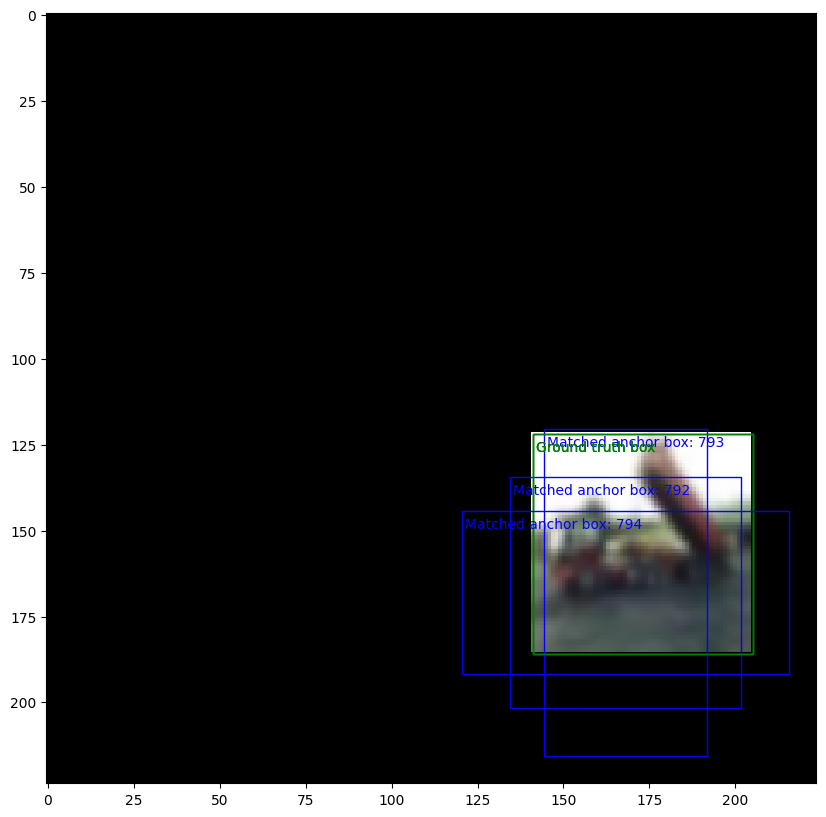

In [11]:
show(image[2], label[2], IMG_SIZE, IMG_SIZE)

## Construct a model

이제 모델을 구성할 차례이다. 지난 실습때 구성한 MobiletNet V2를 기본으로 하여 Detection Layer들을 추가해 주는 방식으로 진행한다. 아래 두 함수(_make_divisible, _inverted_res_block)는 MobileNet V2와 동일한 Helper Function이다.

In [12]:
def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor) # 더 가까운 divisor의 배수로 올림 4,5,6,7,8,9,10,11 -> 8, 12~19 -> 16 ...
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

In [13]:
def _inverted_res_block(inputs, expansion, stride, alpha, filters, block_id):
    #Get the channel axis and the input channel size
    channel_axis = 1 if backend.image_data_format() == 'channels_first' else -1
    in_channels = backend.int_shape(inputs)[channel_axis]
    
    pointwise_conv_filters = int(alpha * filters)
    pointwise_filters = _make_divisible(pointwise_conv_filters, 8) # Make sure the output filter size is the multiple of 8
    
    #Set the prefix
    prefix = 'block_{}_'.format(block_id)
    
    x = inputs
    
    #Expansion block    
    if block_id: # No expansion for block 0
        x = layers.Conv2D(filters = expansion * in_channels, kernel_size = 1, strides = 1, padding='same',
                          use_bias=False, activation=None, kernel_regularizer=regularizers.l2(0.00004),
                          name=prefix + 'expand')(x)
        x = layers.BatchNormalization(axis=channel_axis, momentum=0.999, epsilon=0.001, 
                                      name=prefix + 'expand_BN')(x)
        x = layers.ReLU(6, name=prefix + 'expand_relu')(x)
    else: 
        prefix = 'expanded_conv_'
    
    
    #Depthwise convolution
    #if stride == 2:
        #Adjust zero paddings for strides, when input hieght and width are odd add (1,1,1,1) padding / when even, add (0,1,0,1)
        #x = layers.ZeroPadding2D(padding=correct_pad(x, 3),
        #                         name=prefix + 'pad')(x)
    
    x = layers.DepthwiseConv2D(kernel_size = 3, strides = stride, 
                               #padding='same' if stride == 1 else 'valid',
                               padding='same',
                               use_bias=False, activation=None, kernel_regularizer=regularizers.l2(0.00004),
                               name=prefix + 'depthwise')(x)
    x = layers.BatchNormalization(axis=channel_axis, momentum=0.999, epsilon=0.001,
                                 name=prefix + 'depthwise_BN')(x)
    x = layers.ReLU(6, name=prefix + 'relu')(x)
    
    #Pointwise convolution(Bottleneck)
    x = layers.Conv2D(filters = pointwise_filters, kernel_size = 1, strides = 1, padding='same',
                      use_bias=False, activation=None, kernel_regularizer=regularizers.l2(0.00004),
                      name=prefix + 'project')(x)
    x = layers.BatchNormalization(axis=channel_axis, momentum=0.999, epsilon=0.001,
                                 name=prefix + 'project_BN')(x)
    
    #Inverted residual only when valid(Input size = output_size)
    if in_channels == pointwise_filters and stride == 1:
        return layers.add([inputs, x])
    return x

추후 좌표 복원의 편의를 위하여 각 Predicted box별로 Default anchor box의 좌표들을 붙여주는데, 아래는 이를 생성하기 위한 코드이다. Default anchor box의 좌표 생성 과정은 Training label 생성 과정과 동일하다.

In [14]:
from tensorflow.keras.layers import Layer, InputSpec

class AnchorBoxes(Layer):    
    def __init__(self, layer_width, n_class_withbg, num_boxes,
                 s_max, s_min, aspect_ratio, index, **kwargs):             
        self.layer_width = layer_width
        self.n_class_withbg = n_class_withbg
        self.num_boxes = num_boxes
        self.s_max = s_max
        self.s_min = s_min
        self.aspect_ratio = aspect_ratio
        self.index = index    
        super(AnchorBoxes, self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.input_spec = [InputSpec(shape=input_shape)]
        super(AnchorBoxes, self).build(input_shape)
    
    def compute_output_shape(self, input_shape):
        if K.image_dim_ordering() == 'tf':
            batch_size, feature_map_height, feature_map_width, feature_map_channels = input_shape
       
        return (batch_size, feature_map_height*feature_map_width*self.n_boxes, 4)
    
    def get_config(self):
        config = {
            'layer_width': list(self.layer_width),                        
            'n_class_withbg': self.n_class_withbg,
            'num_boxes': self.num_boxes,
            's_max': self.s_max,
            's_min': self.s_min,
            'aspect_ratio': list(self.aspect_ratio)            
        }
        base_config = super(AnchorBoxes, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
    def call(self, x, mask=None):
        s = self.s_min + (self.s_max - self.s_min) / (len(self.layer_width) - 1) * (len(self.layer_width) - self.index - 1)
        l = self.layer_width[self.index]            
        num_box = self.num_boxes[self.index]            
        box_tensor = np.zeros((l * l * num_box, 4))
        for i in range(self.layer_width[self.index]):                    
            for j in range(self.layer_width[self.index]):
                for box_idx in range(num_box):
                    box_tensor[(i * l + j) * num_box + box_idx, 0] = (0.5 + i) / l
                    box_tensor[(i * l + j) * num_box + box_idx, 1] = (0.5 + j) / l
                    box_tensor[(i * l + j) * num_box + box_idx, 2] = s * math.sqrt(aspect_ratio[box_idx]) / l
                    box_tensor[(i * l + j) * num_box + box_idx, 3] = s / math.sqrt(aspect_ratio[box_idx]) / l
        box_tensor = np.expand_dims(box_tensor, axis = 0)
        return tf.tile(tf.constant(box_tensor, dtype=tf.float32), (tf.shape(x)[0],1,1))

MobileNet V2 모델을 변형하여 MobileNetV2SSD로 만들어 주자. 4번째 Bottleneck block을 통과한 뒤 첫번째 Detection Layer(가장 촘촘한 격자)가 연결되도록 해주고, 2개의 Convolution layer를 통과한 뒤 두번째 Detection Layer가 연결되도록 해주자. 3~5번째 Detection layer는 2번째 Detection Layer와 동일한 방식으로 차례로 연결되도록 구성한다. <br>

**Note:**
* Classification과 Localization을 위한 Layer를 따로 생성한 뒤, 나중에 Concatenate를 통해 합쳐주는 방식으로 구성한다. 하나의 layer로 생성하게되면, Classification에 Softmax를 적용하기가 어렵다.
* 위에 정의된 Anchor Box 함수를 이용하여 Default Anchor Box의 좌표를 상수로 입력해 둔다. 나중에 좌표 복원시에 용이하게 사용할 수 있다.

In [15]:
def MobileNetV2SSD(input_shape,
                n_classes,
                layer_width,
                num_boxes,
                alpha=1.0):
    
    n_class_withbg = n_classes + 1 # Add background class
    
    inputs = layers.Input(shape=input_shape)
    
    first_block_filters = _make_divisible(32 * alpha, 8)
    # first conv layer: 224x224x3 -> 112x112x32
    x = layers.Conv2D(first_block_filters, kernel_size=3, strides=(2, 2), padding='same',  use_bias=False, 
                      bias_initializer='zeros',  kernel_regularizer=regularizers.l2(0.00004),
                      name='Conv1')(inputs)
    
    x = layers.BatchNormalization(
      axis=-1, epsilon=1e-3, momentum=0.999, name='bn_Conv1')(x)
    
    x = layers.ReLU(6., name='Conv1_relu')(x)
    
    
    # inverted residual blocks
    # 1st bottleneck block: 112x112x32 -> 112x112x16
    x = _inverted_res_block(
      x, filters=16, alpha=alpha, stride=1, expansion=1, block_id=0)

    # 2nd bottleneck block: 112x112x16 -> 56x56x24
    x = _inverted_res_block(
      x, filters=24, alpha=alpha, stride=2, expansion=6, block_id=1)
    x = _inverted_res_block(
      x, filters=24, alpha=alpha, stride=1, expansion=6, block_id=2)

    # 3rd bottleneck block: 56x56x24 -> 28x28x32
    x = _inverted_res_block(
      x, filters=32, alpha=alpha, stride=2, expansion=6, block_id=3)
    x = _inverted_res_block(
      x, filters=32, alpha=alpha, stride=1, expansion=6, block_id=4)
    x = _inverted_res_block(
      x, filters=32, alpha=alpha, stride=1, expansion=6, block_id=5)

    # 4th bottleneck block: 28x28x32 -> 14x14x64
    x = _inverted_res_block(
      x, filters=64, alpha=alpha, stride=2, expansion=6, block_id=6)
    x = _inverted_res_block(
      x, filters=64, alpha=alpha, stride=1, expansion=6, block_id=7)
    x = _inverted_res_block(
      x, filters=64, alpha=alpha, stride=1, expansion=6, block_id=8)
    x = _inverted_res_block(
      x, filters=64, alpha=alpha, stride=1, expansion=6, block_id=9)
        
    classifier_1_conf = layers.Conv2D(num_boxes[0] * n_class_withbg, kernel_size = 3, padding='same', use_bias=False, name='classifier_1_conf')(x)
    classifier_1_loc = layers.Conv2D(num_boxes[0] * 4, kernel_size = 3, padding='same', use_bias=False, name='classifier_1_loc')(x)
    

    x = layers.Conv2D(256, kernel_size=1, padding='same', use_bias=False, activation='relu')(x)
    x = layers.Conv2D(512, kernel_size=3, strides=2, padding='same', use_bias=False, activation='relu')(x) #7x7
    
    classifier_2_conf = layers.Conv2D(num_boxes[1] * n_class_withbg, kernel_size = 3, padding='same', use_bias=False, name='classifier_2_conf')(x)
    classifier_2_loc = layers.Conv2D(num_boxes[1] * 4, kernel_size = 3, padding='same', use_bias=False, name='classifier_2_loc')(x)
        
    x = layers.Conv2D(128, kernel_size=1, padding='same', use_bias=False, activation='relu')(x)
    x = layers.Conv2D(256, kernel_size=3, strides=2, padding='same', use_bias=False, activation='relu')(x) # 4x4
    
    classifier_3_conf = layers.Conv2D(num_boxes[2] * n_class_withbg, kernel_size = 3, padding='same', use_bias=False, name='classifier_3_conf')(x)
    classifier_3_loc = layers.Conv2D(num_boxes[2] * 4, kernel_size = 3, padding='same', use_bias=False, name='classifier_3_loc')(x)    
        
    x = layers.Conv2D(128, kernel_size=1, padding='same', use_bias=False, activation='relu')(x)
    x = layers.Conv2D(256, kernel_size=3, strides=2, padding='same', use_bias=False, activation='relu')(x) # 2x2
    
    classifier_4_conf = layers.Conv2D(num_boxes[3] * n_class_withbg, kernel_size = 3, padding='same', use_bias=False, name='classifier_4_conf')(x)
    classifier_4_loc = layers.Conv2D(num_boxes[3] * 4, kernel_size = 3, padding='same', use_bias=False, name='classifier_4_loc')(x)   
    
    x = layers.Conv2D(128, kernel_size=1, padding='same', use_bias=False, activation='relu')(x)
    x = layers.Conv2D(256, kernel_size=3, strides=2, padding='same', use_bias=False, activation='relu')(x) # 1x1
    
    classifier_5_conf = layers.Conv2D(num_boxes[4] * n_class_withbg, kernel_size = 3, padding='same', use_bias=False, name='classifier_5_conf')(x)
    classifier_5_loc = layers.Conv2D(num_boxes[4] * 4, kernel_size = 3, padding='same', use_bias=False, name='classifier_5_loc')(x)

    
    ### 아래 실습하면서 완성
    #Classification tensors    
    classifier_1_conf = layers.Reshape((layer_width[0] * layer_width[0] * num_boxes[0], n_class_withbg))(classifier_1_conf)
    classifier_2_conf = layers.Reshape((layer_width[1] * layer_width[1] * num_boxes[1], n_class_withbg))(classifier_2_conf)
    classifier_3_conf = layers.Reshape((layer_width[2] * layer_width[2] * num_boxes[2], n_class_withbg))(classifier_3_conf)
    classifier_4_conf = layers.Reshape((layer_width[3] * layer_width[3] * num_boxes[3], n_class_withbg))(classifier_4_conf)
    classifier_5_conf = layers.Reshape((layer_width[4] * layer_width[4] * num_boxes[4], n_class_withbg))(classifier_5_conf)   
    
    conf_layers = layers.concatenate([classifier_1_conf, classifier_2_conf, classifier_3_conf, classifier_4_conf, classifier_5_conf], axis = 1)
    
    
    #Apply softmax
    conf_layers_softmax = layers.Activation('softmax')(conf_layers)    
    
    #Localization tensors
    classifier_1_loc = layers.Reshape((layer_width[0] * layer_width[0] * num_boxes[0], 4))(classifier_1_loc)
    classifier_2_loc = layers.Reshape((layer_width[1] * layer_width[1] * num_boxes[1], 4))(classifier_2_loc)
    classifier_3_loc = layers.Reshape((layer_width[2] * layer_width[2] * num_boxes[2], 4))(classifier_3_loc)
    classifier_4_loc = layers.Reshape((layer_width[3] * layer_width[3] * num_boxes[3], 4))(classifier_4_loc)
    classifier_5_loc = layers.Reshape((layer_width[4] * layer_width[4] * num_boxes[4], 4))(classifier_5_loc)    
    
    loc_layers = layers.concatenate([classifier_1_loc, classifier_2_loc, classifier_3_loc, classifier_4_loc, classifier_5_loc], axis = 1)
    
    #Default anchor box tensors, They are constant and NOT trained !!
    #def __init__(self, layer_width, n_class_withbg, num_boxes, s_max, s_min, aspect_ratio, index, **kwargs):     
    dbox_1 = AnchorBoxes(layer_width, n_class_withbg, num_boxes, s_max, s_min, aspect_ratio, index = 0)(classifier_1_loc)
    dbox_2 = AnchorBoxes(layer_width, n_class_withbg, num_boxes, s_max, s_min, aspect_ratio, index = 1)(classifier_2_loc)
    dbox_3 = AnchorBoxes(layer_width, n_class_withbg, num_boxes, s_max, s_min, aspect_ratio, index = 2)(classifier_3_loc)
    dbox_4 = AnchorBoxes(layer_width, n_class_withbg, num_boxes, s_max, s_min, aspect_ratio, index = 3)(classifier_4_loc)
    dbox_5 = AnchorBoxes(layer_width, n_class_withbg, num_boxes, s_max, s_min, aspect_ratio, index = 4)(classifier_5_loc)
    
    dbox_layers = layers.concatenate([dbox_1, dbox_2, dbox_3, dbox_4, dbox_5], axis = 1)   
    
    ### 실습 끝
    
    
    #Concatenate Classification tensor, Localization tensor and Default anchor box tensor.
    detections = layers.concatenate([conf_layers_softmax, loc_layers, dbox_layers], axis=-1)

    outputs = detections
    
    return Model(inputs=inputs, outputs=outputs)
    

In [16]:
model = MobileNetV2SSD((IMG_SIZE, IMG_SIZE, 3), n_classes, layer_width, num_boxes, alpha=1.0)

In [18]:
model.load_weights('./training_checkpoints_SSD/ckpt_1', by_name=False)

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

## Loss function
SSD Loss는 Tensorflow에서 기본적으로 제공하지 않으므로, 직접 생성해 주어야 한다.
* Localization loss: L2 Loss를 사용한다. Positive box에만 적용한다.(Ground truth와 매칭된 anchor box)
* Confidence loss: Cross entropy loss를 사용한다. 다만 Positive box와 Negative box를 구분하여 각각에 대한 Loss를 따로 구하고 합쳐준다. 

In [22]:
class SSDLoss():
    def __init__(self, n_classes, background_id, neg_pos_ratio=3, n_neg_min=0, alpha=1.0, beta=1.0):
        self.neg_pos_ratio = neg_pos_ratio
        self.n_neg_min = 0
        self.alpha = alpha
        self.beta = beta
        self.background_id = background_id
        self.n_class_withbg = n_classes + 1
        
    def L2Loss(self, loc_true, loc_pred):
        """
        y_true: ground truth localization tensor, shape: (batch_size, num_boxes, 4)
        y_pred: predicted localization tensor, shape: (batch_size, num_boxes, 4)
        """
        diff = tf.abs(loc_pred - loc_true)        
        l2_loss = diff ** 2

        return tf.reduce_sum(l2_loss, axis=-1)
    
    def smoothL1Loss(self, loc_true, loc_pred):
        """
        y_true: ground truth localization tensor, shape: (batch_size, num_boxes, 4)
        y_pred: predicted localization tensor, shape: (batch_size, num_boxes, 4)
        """
        return 0
    
    
    def log_loss(self, class_true, class_pred):
        #classification loss
        class_pred = tf.maximum(class_pred, 1e-15)
        log_loss = -tf.reduce_sum(class_true * tf.math.log(class_pred), axis=-1)  # (batch_size, n_boxes)   
        return log_loss
        
    def compute_loss(self, y_true, y_pred):    
        """
        y_true: (batch_size, # boxes, n_class_withbg + 4)
        y_pred: (batch_size, # boxes, n_class_withbg + 4)
        """
        
        #Get the size of tensor
        batch_size = tf.shape(y_true)[0]
        n_boxes = tf.shape(y_pred)[1]
        
        y_true = tf.cast(y_true, dtype=tf.float32)
        y_pred = tf.cast(y_pred, dtype=tf.float32)
                
        classification_loss = self.log_loss(y_true[:, :, :self.n_class_withbg], y_pred[:, :, :self.n_class_withbg])
        positives = tf.reduce_max(y_true[:, :, 1:(self.n_class_withbg)], axis=-1) # Class is NOT background, (batch_size, n_boxes)       
        
        # Classification loss for positive boxes
        pos_class_loss = tf.reduce_sum(self.log_loss(y_true[:, :, 1:self.n_class_withbg], y_pred[:, :, 1:self.n_class_withbg]), axis=-1)
        
        negatives = y_true[:,:, self.background_id] # Class is background, (batch_size, n_boxes)
        n_positives = tf.reduce_sum(positives) # number of positive boxes, single number
        
        # Classification loss for negative boxes
        neg_class_loss_all = classification_loss * negatives #(batch_size, n_boxes)        
        n_neg_losses = tf.math.count_nonzero(neg_class_loss_all, dtype=tf.int32) # The number of nonzero entries in neg_class_loss_all
        
        # Keep the number of negative boxes between n_neg_min and neg_pos_ratio * positive_boxes        
        n_negative_keep = tf.minimum(tf.maximum(self.neg_pos_ratio * tf.cast(n_positives, dtype=tf.int32), self.n_neg_min), n_neg_losses)
        
        def f1():
            return tf.zeros([batch_size])
        
        # Get the "n_negative_keep" largest confidence negative boxes.
        def f2():
            #Resahpe neg_class_loss_all to 1d array
            neg_class_loss_all_1D = tf.reshape(neg_class_loss_all, [-1])

            # Find top 'n_negative_keep' boxes from neg_class_loss_all_1D
            values, indices = tf.nn.top_k(neg_class_loss_all_1D, k=n_negative_keep, sorted=False)

            #Then create a mask for negative boxes: For selected box above, set them as 1
            negatives_keep = tf.scatter_nd(indices=tf.expand_dims(indices, axis=1),
                                           updates=tf.ones_like(indices, dtype=tf.int32),
                                           shape=tf.shape(neg_class_loss_all_1D))
            negatives_keep = tf.cast(tf.reshape(negatives_keep, [batch_size, n_boxes]), dtype=tf.float32)            

            #Finally compute negative loss
            neg_class_loss = tf.reduce_sum(classification_loss * negatives_keep, axis=-1) #(batch_size)
            
            return neg_class_loss
        
        neg_class_loss = tf.cond(tf.equal(n_neg_losses, tf.constant(0)), f1, f2)           
        
        #Final classification loss: Sum of positive and negative loss
        class_loss = self.beta * pos_class_loss + neg_class_loss
        
        #localization loss
        loc_pred = y_pred[:,:,self.n_class_withbg:-4]
        loc_true = y_true[:,:,self.n_class_withbg:-4]
        loc_loss = self.L2Loss(loc_true, loc_pred) # (batch_size, n_boxes)       
        
        # Include only positive boxes in calculating localization loss
        loc_loss = tf.reduce_sum(positives * loc_loss, axis=-1) #(batch_size)     
        
        #Combine localization and classification loss, divide by matched default box(n_positives)
        total_loss = (class_loss + loc_loss * self.alpha) / tf.maximum(1.0, n_positives)
        
        # We divided by n_positives - # of all matched default boxes of "a batch"
        # Since keras divides by the size of batch, it is double division
        # To adjust this, we multiply by batch_size
        total_loss = total_loss * tf.cast(batch_size, dtype=tf.float32)
        
        return total_loss

## Model compile and Training


모델을 컴파일 하고 트레이닝을 시작하자.<br>
* Optimizer: Adam을 사용하되, Learning schedule을 통해 Learning rate를 조정해 주자.
* Loss: 위에서 정의한 SSDLoss를 사용하자.

In [23]:
ssd_loss = SSDLoss(n_classes = n_classes, background_id=0, neg_pos_ratio=1, alpha=10, beta=3)
model.compile(loss=ssd_loss.compute_loss,     
              optimizer=tf.keras.optimizers.Adam())
              #optimizer=tf.keras.optimizers.SGD(lr=0.001, momentum=0.9, decay=0))

CallBack 함수를 지정하면 필요한 대로 트레이닝 옵션들을 추가할 수 있다.

In [25]:
#decay could be applied using Learning rate scheduler
def decay(epoch):
    return 0.001 * (0.98 **(epoch - 1))

In [26]:
callbacks = []
"""
#TensorBoard로 훈련 성과를 보고 싶은 경우
callbacks.append(TensorBoard(log_dir=log_dir, histogram_freq=1))
"""

#Checkpoint설정
checkpoint_dir = './training_checkpoints_SSD'
model_cp_path = os.path.join(checkpoint_dir, "ckpt_{epoch}")
callbacks.append(tf.keras.callbacks.ModelCheckpoint(model_cp_path, save_weights_only=True))


#Learning rate 스케쥴 설정
callbacks.append(LearningRateScheduler(decay))

#General logs on csv
callbacks.append(CSVLogger(model_csv_path)) 

In [27]:
model.load_weights(os.path.join(checkpoint_dir, "ckpt_1"))

In [162]:
history = model.fit(ssd_input_gen,              
              epochs=50,
              verbose=1,
              callbacks=callbacks)              

3125/3125 [==============================] - 209s 67ms/step - loss: 1.6038


## Prediction and Evaluation

이제 트레이닝된 모델을 이용하여 Detection이 잘 되는지 확인해 보자. 먼저 Training image, label을 이용하여 Ground truth box와 비교해 볼 것이다. Training data generator로부터 나온 image batch를 model에 넣어 predict를 해보자.

In [28]:
y_pred = model.predict(image)

2022-08-18 13:40:51.494103: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-08-18 13:40:51.512399: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2400000000 Hz
2022-08-18 13:40:52.149719: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-08-18 13:40:52.986801: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2022-08-18 13:40:54.253599: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-08-18 13:40:55.204302: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


아래 함수들을 통해 y_pred로부터 탐지된 Bounding Box를 찾아낸다.
- `def _greedy_nms(predictions, iou_threshold=0.45):`
    - Non-max suppression을 수행한다. Confidence가 높게 예측된 Box들을 뽑아낸 후, 겹치는 비율(IoU)이 높은 Box들을 제거해 주는 함수이다.
- `def decode_detections(y_pred, n_classes, confidence_thresh, iou_threshold, top_k, img_height,img_width, background_id):`
    - 예측된 Box들을 다시 원본 코드의 좌표로 복원해 주는 작업을 수행한다.

In [29]:
from utils import decode_detections

In [30]:
# Decode the prediction for one image in the image batch
image_no = 0
y_decoded = decode_detections(np.expand_dims(y_pred[image_no], axis=0),
                            n_classes=10, 
                              confidence_thresh=0.01, 
                              iou_threshold=0.45, 
                              top_k=10, 
                              img_height=IMG_SIZE, 
                              img_width=IMG_SIZE,
                              background_id=0)

/home/keondopark/a2i/Practice4/utils.py:166: RuntimeWarning: overflow encountered in multiply
  y_pred_decoded_raw[:,:,[-4,-2]] *= img_width # Convert xmin, xmax back to absolute coordinates


In [31]:
y_pred[image_no,:,0]

array([1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e

예측된 Bounding box를 Image 위에 시각화 해보자.

In [34]:
# Visualize the bounding box on the original image
import matplotlib.patches as patches

def show_prediction(image, label, prediction):
    
    fig,ax = plt.subplots(1, figsize=(10,10))
    ax.imshow(image)
    gt_boxes = np.argwhere(label[:,0]==0)
    for match in gt_boxes:        
        anchor_box = label[match[0],-4:]
        gt_box = label[match[0], -8:-4]
        class_id = np.argwhere(label[match[0],:10]==1)        
                
        w = math.exp(gt_box[2]) * anchor_box[2]
        h = math.exp(gt_box[3]) * anchor_box[3]
        cx = gt_box[0] * anchor_box[2] + anchor_box[0]
        cy = gt_box[1] * anchor_box[3] + anchor_box[1]
        
        xmin = (cx - w/2) * IMG_SIZE
        ymin = (cy - h/2) * IMG_SIZE
        w = w * IMG_SIZE
        h = h * IMG_SIZE        
        
        rect = patches.Rectangle((ymin,xmin),h, w,linewidth=1,edgecolor='g',facecolor='none')
        ax.add_patch(rect)
        ax.text(ymin+1, xmin+w-5, 'ground truth: ' + str(class_id[0,0]), color='g')            
    
    pred_boxes= np.argwhere(prediction[:,1] > 0)    
        
    for pred in pred_boxes:
        box = prediction[pred[0],2:6]
        class_id = int(prediction[pred[0],0])   
        prob = prediction[pred[0],1]
        xmin = min(max(box[0],0),224)
        ymin = min(max(box[1],0),224)
        w = min(max(box[2],0),224) - xmin
        h = min(max(box[3],0),224) - ymin
        rect = patches.Rectangle((ymin,xmin),h, w,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)        
        ax.text(ymin+1, xmin+5, 'class: {}, prob: {:.2f}'.format(class_id, prob), color='r')
        
    plt.show()

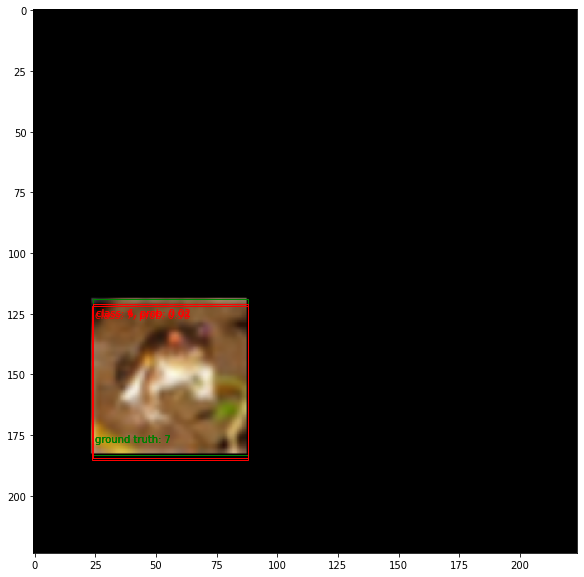

In [35]:
show_prediction(image[image_no],label[image_no],y_decoded[0])

이제 테스트 셋에 대해서도 예측을 해보고, Evaluation을 해 볼 차례이다. 먼저 SSDInputEncodingGenerator 클래스에 테스트셋(x_test, y_test)를 넣어 테스트용 Generator를 준비하도록 하자.

In [41]:
ssd_test_gen = SSDInputEncodingGenerator(IMG_SIZE, 
                 IMG_SIZE, 
                 layer_width=layer_width, 
                 n_classes=n_classes, 
                 num_boxes=num_boxes, 
                 s_max=s_max, 
                 s_min=s_min, 
                 aspect_ratio=aspect_ratio, 
                 pos_iou_threshold=pos_iou_threshold,
                 neg_iou_threshold=neg_iou_threshold,
                 background_id=0,
                 images=x_test,
                 labels=y_test,
                data_size=test_size,
                batch_size=batch_size)

테스트 셋의 이미지에 대해서 예측이 잘 되는지 확인을 해보자.

In [42]:
test_image, test_label = next(iter(ssd_test_gen))

In [43]:
test_pred = model.predict(test_image)

In [46]:
image_no = 0
test_decoded = decode_detections(np.expand_dims(test_pred[image_no], axis=0),
                            n_classes=10, 
                              confidence_thresh=0.01, 
                              iou_threshold=0.45, 
                              top_k=100, 
                              img_height=IMG_SIZE, 
                              img_width=IMG_SIZE,
                              background_id=0)

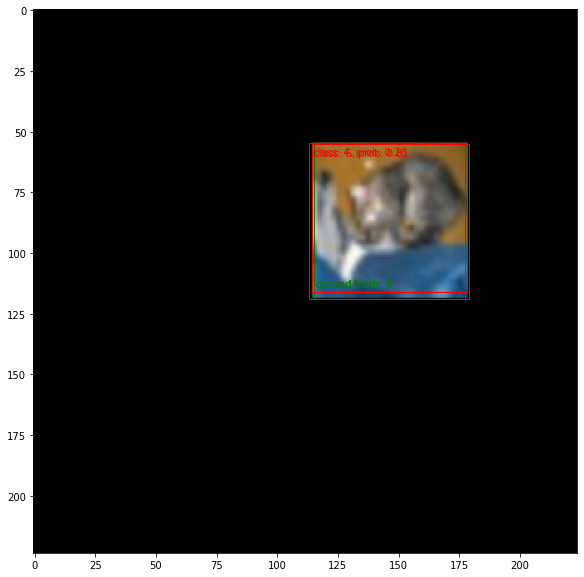

In [47]:
show_prediction(test_image[image_no],test_label[image_no],test_decoded[0])

### Evaluation
이제 Detection 성능을 측정해 볼 것이다. Detection 성능은 보통 mAP(mean Average Precision)으로 측정한다. 여러 Challenge에 따라 조금씩 기준이 다른데 우리는 COCO mAP를 이용하여 성능을 측정해 보기로 한다.
- mAP에 관한설명 참고 사이트: https://blog.zenggyu.com/en/post/2018-12-16/an-introduction-to-evaluation-metrics-for-object-detection/
- COCO challenge mAP 기준에 관한 설명: https://cocodataset.org/#detection-eval

COCO 기준의 mAP를 측정하기 위해서는 pycocotools 패키지를 사용하면 된다. 다만, Ground truth와 Detection 결과는 직접 json 형태로 만들어 주어야 한다. 아래 코드들을 통해 필요한 파일들을 준비할 수 있다.

In [51]:
# Function to dump prediction result in JSON format
import json

def dump_coco_json(dataset_size, batch_size, generator, model, out_file):
    
    # Put the results in this list.
    results = []
    id_cnt = 0    
    
    for batch_X, batch_label in generator:
        # Generate batch.
        #batch_X, batch_label = next(generator)
        # Predict.
        y_pred = model.predict(batch_X)

        # Decode.
        y_pred = decode_detections(y_pred,
                                   n_classes=10, 
                                   confidence_thresh=0.01,
                                   iou_threshold=0.45,
                                   top_k=200,                               
                                   img_height=IMG_SIZE, 
                                  img_width=IMG_SIZE,
                                  background_id=0)
        
        # Convert each predicted box into the results format.
        for k, batch_item in enumerate(y_pred):
            for box in batch_item:                
                cat_id = box[0]
                # Round the box coordinates to reduce the JSON file size.
                xmin = float(round(box[2], 1))
                ymin = float(round(box[3], 1))
                xmax = float(round(box[4], 1))
                ymax = float(round(box[5], 1))
                width = xmax - xmin
                height = ymax - ymin
                bbox = [xmin, ymin, width, height]
                result = {}
                result['image_id'] = id_cnt
                result['category_id'] = cat_id                
                result['score'] = float(round(box[1], 3))
                result['bbox'] = bbox
                results.append(result)                   
            id_cnt += 1
            if id_cnt == dataset_size:
                break 
            
    
    with open(out_file, 'w') as f:
        json.dump(results, f)

    print("Prediction results saved in '{}'".format(out_file))
    return

In [52]:
# Prediction to coco format
generator = ssd_test_gen
dataset_size = test_size
#dataset_size = 128
out_file='prediction_coco_format.json'

In [53]:
dump_coco_json(dataset_size, batch_size, generator, model, out_file)

Prediction results saved in 'prediction_coco_format.json'


In [54]:
#Get the coordinates of ground truth image from the generator
xmin_test = np.expand_dims(ssd_test_gen.xmin_random, axis=-1)
ymin_test = np.expand_dims(ssd_test_gen.ymin_random, axis=-1)
xmax_test = np.expand_dims(ssd_test_gen.xmin_random + 64, axis=-1)
ymax_test = np.expand_dims(ssd_test_gen.ymin_random + 64, axis=-1)

#Prepare ground truth boxes information(class_id, confidence(dummy), xmin, ymin, xmax, ymax)
gt_boxes = np.concatenate([y_test, np.ones([test_size,1]), xmin_test, ymin_test, xmax_test, ymax_test], axis = -1)

In [65]:
# Store gt information in coco format
images = []
results = []
categories = []

for i in range(dataset_size):
    im = {}
    im['id'] = i
    im['width'] = IMG_SIZE
    im['height'] = IMG_SIZE
    im['file_name'] = 'image.jpg'
    images.append(im)
    
for i in range(n_classes):
    cat = {}
    cat['id'] = i
    cat['name'] = class_names[i]
    cat['supercategory'] = cat['name']
    categories.append(cat)
    
id_cnt = 0

for box in gt_boxes:
    class_id = box[0]+1
    # Transform the consecutive class IDs back to the original COCO category IDs.
    #cat_id = classes_to_cats[class_id]
    cat_id = class_id
    # Round the box coordinates to reduce the JSON file size.
    xmin = float(round(box[2], 1))
    ymin = float(round(box[3], 1))
    xmax = float(round(box[4], 1))
    ymax = float(round(box[5], 1))
    width = xmax - xmin
    height = ymax - ymin
    bbox = [xmin, ymin, width, height]
    result = {}
    result['id'] = id_cnt
    result['image_id'] = id_cnt
    result['category_id'] = cat_id
    result['bbox'] = bbox
    result['iscrowd'] = 0
    result['area'] = width * height
    results.append(result)        
    id_cnt += 1
    
    if id_cnt == dataset_size:
        break

output_dict = {}
output_dict["images"] = images
output_dict["annotations"] = results
output_dict["categories"] = categories

out_file='gt_coco_format.json'

with open(out_file, 'w') as f:
    json.dump(output_dict, f)

필요한 파일들이 준비되었으며 pycocotools 패키지를 이용하여 Evaluation을 수행한다.

In [66]:
pip install pycocotools

Note: you may need to restart the kernel to use updated packages.


In [67]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

In [68]:
coco_gt = COCO('gt_coco_format.json')

loading annotations into memory...
Done (t=0.56s)
creating index...
index created!


In [69]:
coco_dt = coco_gt.loadRes('prediction_coco_format.json')

Loading and preparing results...
DONE (t=0.10s)
creating index...
index created!


In [70]:
image_ids = sorted(coco_gt.getImgIds())

In [71]:
cocoEval = COCOeval(cocoGt=coco_gt,
                    cocoDt=coco_dt,
                    iouType='bbox')
cocoEval.params.imgIds  = image_ids
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=8.36s).
Accumulating evaluation results...
DONE (t=1.75s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.515
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.755
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.613
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.515
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.703
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.705
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.705
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=

In [64]:
class evaluation_mAP(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (0 < epoch and epoch % 5 == 0) or epoch >= 10:
        #if epoch >= 0:
            print('\n')
            print('Start evalutaion')
            dump_coco_json(test_size, batch_size, ssd_test_gen, model, 'prediction_coco_format.json')
            coco_dt = coco_gt.loadRes('prediction_coco_format.json')
            image_ids = sorted(coco_gt.getImgIds())
            cocoEval = COCOeval(cocoGt=coco_gt,
                    cocoDt=coco_dt,
                    iouType='bbox')
            cocoEval.params.imgIds  = image_ids
            cocoEval.evaluate()
            cocoEval.accumulate()
            cocoEval.summarize()
           
callbacks.append(evaluation_mAP())

# 추가로 생각/시도해볼만한 것들

1. 현재 모델에는 총 5개의 Detection layer가 구현되어 있는데, 논문 원본에서처럼 Detection layer를 6개로 만들어 볼 수 있음.
2. Box의 종류도 3가지로 구현되어 있는데 더욱 다양한 Anchor box를 이용해 볼 수 있음.
3. Callback을 이용하여 Training중에 개별 Loss의 값이 출력되거나 COCO Validation을 수행하도록 해볼 수 있음.
4. 현재 L2 Loss로 구현되어 있는데 논문과 동일하게 Smooth L1 Loss를 구현해 볼 수 있음. 또한, Positive - Negative 불균형 문제를 해결하기 위해 RetinaNet에서는 Focal loss라는 개념을 도입하였는데 이를 구현해 볼 수 있음 (참고: https://arxiv.org/abs/1708.02002)
5. COCO tool을 사용하지 않고 mAP를 직접 계산할 수 있도록 구현해보기.